In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 

stopwords = set(STOPWORDS)
stopwords.add('')

In [87]:
def bagoword(lst):
    cnt = Counter()
    for word in lst:
        cnt[word]+=1
    return cnt

def bagoword_corpus(lst, stopwords):
    cnt = Counter()
    for r in lst:
        for word in wordlist(r):
            if word not in stopwords:
                cnt[word]+=1
    return cnt


def wordlist(review):
    '''
    Convert a review into a list of words(strings).
    '''
    lines = review.split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip().lower(), lines)
    return list(words)

In [6]:
df = pd.read_csv('train.csv')
df.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


### Note 1:= fake review & 0:= genuine review

In [42]:
df[df['label']==1]['review']

0         The food at snack is a selection of popular Gr...
1         This little place in Soho is wonderful. I had ...
2         ordered lunch for 15 from Snack last Friday.  ...
3         This is a beautiful quaint little restaurant o...
4         Snack is great place for a  casual sit down lu...
                                ...                        
250677    This place is amazing, I loved it so much that...
250678    I love this place. Drinks are great, atmospher...
250679    Bijan is the best bar I have been to in Brookl...
250680    Great local lounge spot! After work and regula...
250793    First and last time we try this place.  Pizza ...
Name: review, Length: 25819, dtype: object

In [83]:
df[df['label']==0]['review']

11        I had the braised lamb sandwich and was one of...
12        This spot is close to my job so I decided to c...
13        Needed a quick, healthy light "lunch" and this...
14        Their artichoke chicken salad is good and plenty.
15        Needed a quick bite and stopped here because o...
                                ...                        
250869    Made a reservation for an early dinner Saturda...
250870    Emily is like Franny's Marco, but with warmth ...
250871    Can't say enough good things about this place....
250872    Had a great dinner here- fantastic pizza, the ...
250873    Pizza Loves Emily and I love Emily's pizza. Th...
Name: review, Length: 225055, dtype: object

In [105]:
# Fake Review Bag Of Words & WordCloud

bow_fake = bagoword_corpus(df[df['label']==1]['review'], stopwords)
bow_fake_sort = sorted(bow_fake.items(), key=lambda x: x[1], reverse=True)
bow_fake_sort

[('food', 17022),
 ('place', 13451),
 ('good', 11757),
 ('great', 11605),
 ('service', 7612),
 ('go', 6267),
 ('one', 6200),
 ('really', 5638),
 ('time', 5580),
 ('back', 5455),
 ('restaurant', 5430),
 ('best', 5347),
 ('will', 4849),
 ('us', 4503),
 ('love', 4401),
 ('delicious', 4372),
 ('wait', 4277),
 ('pizza', 4078),
 ('nice', 3717),
 ('menu', 3530),
 ('staff', 3496),
 ('even', 3355),
 ('amazing', 3315),
 ('try', 3294),
 ('well', 3147),
 ('always', 3144),
 ('table', 3102),
 ('went', 3083),
 ('ordered', 3026),
 ('definitely', 3008),
 ('chicken', 2981),
 ('people', 2958),
 ('little', 2866),
 ('bar', 2797),
 ('dinner', 2738),
 ('never', 2726),
 ('order', 2724),
 ('friendly', 2715),
 ('new', 2676),
 ('night', 2672),
 ('got', 2648),
 ('came', 2588),
 ('experience', 2568),
 ('eat', 2527),
 ('first', 2518),
 ('better', 2512),
 ('much', 2508),
 ('make', 2478),
 ('come', 2416),
 ('fresh', 2401),
 ('worth', 2373),
 ('atmosphere', 2359),
 ('meal', 2339),
 ('say', 2317),
 ('wine', 2300),
 ('s

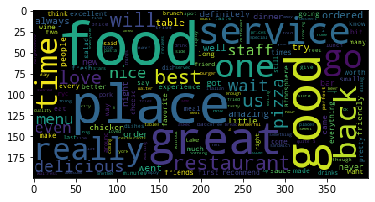

In [107]:
wc_fake = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_fake)
plt.imshow(wc_fake) 

In [106]:
# Genuine Review Bag Of Words & WordCloud

bow_real = bagoword_corpus(df[df['label']==0]['review'], stopwords)
bow_real_sort = sorted(bow_real.items(), key=lambda x: x[1], reverse=True)
bow_real_sort

[('good', 149386),
 ('food', 148697),
 ('place', 139170),
 ('great', 104091),
 ('really', 79042),
 ('one', 78907),
 ('service', 65749),
 ('go', 64179),
 ('back', 62800),
 ('time', 62732),
 ('delicious', 55579),
 ('wait', 51576),
 ('best', 50570),
 ('ordered', 49993),
 ('restaurant', 49222),
 ('got', 47782),
 ('chicken', 47459),
 ('us', 46570),
 ('will', 46412),
 ('little', 45172),
 ('menu', 44641),
 ('nice', 44417),
 ('sauce', 44028),
 ('definitely', 43971),
 ('came', 43797),
 ('well', 43238),
 ('try', 42919),
 ('love', 41294),
 ('even', 39868),
 ('pork', 38616),
 ('pizza', 38140),
 ('pretty', 38046),
 ('order', 37637),
 ('table', 37343),
 ('come', 36582),
 ('much', 36162),
 ('people', 34757),
 ('cheese', 33230),
 ('night', 33194),
 ('amazing', 33012),
 ('small', 32767),
 ('bar', 32387),
 ('dinner', 32362),
 ('went', 31578),
 ('bit', 31277),
 ('first', 31184),
 ('meal', 30713),
 ('two', 30605),
 ('think', 30326),
 ('better', 29559),
 ('eat', 29481),
 ('dish', 29174),
 ('make', 29159),


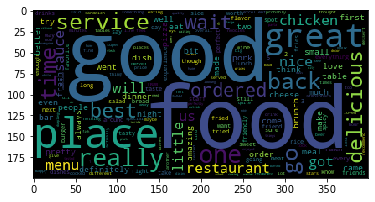

In [108]:
wc_real = WordCloud(stopwords=stopwords).generate_from_frequencies(bow_real)
plt.imshow(wc_real) 